# Compare MPNNs for Bandgap and Atomization Energy
Show the effect of adding layers and rollout choice for two different properties

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from mpnn.layers import MessagePassingLayer, Readout, Squeeze, Scaling
from mpnn.data import make_data_loader
from tqdm import tqdm
import pandas as pd
import numpy as np

2023-08-14 13:31:54.036783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configuration

In [2]:
prop = 'g4mp2_atom'

## Make data loaders
We need one for the training, validation and test sets. These will use the atomization energy for now

In [3]:
train_loader = make_data_loader('datasets/train_data.proto', batch_size=32, output_property=prop, shuffle_buffer=8192)

2023-08-14 13:31:55.743695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 13:31:55.827106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 13:31:55.827275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
valid_loader = make_data_loader('datasets/valid_data.proto', output_property=prop, batch_size=32)

In [5]:
test_loader = make_data_loader('datasets/test_data.proto', batch_size=32, output_property=prop)

# Make a function to build models
This will make experimentation easier later

In [6]:
def make_model(num_features: int, num_messages: int, readout_type: str = 'sum'):
    """Build an MPNN
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
        readout_type: Function sued for the readout
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(readout_type, name='readout')(atom_features, snode_graph_indices)
    
    # Dense layer
    dense = layers.Dense(32, activation='relu', name='dense')(mol_features)
    
    # Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(dense)
    
    # Scaling layer
    scale = Scaling(name='scaling')
    output = scale(output)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output)
    return model

In [7]:
model = make_model(64, 2)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 atom (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 bond (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 squeeze (Lambda)            (None,)                      0         ['node_graph_indices[0][0]',  
                                                                     'atom[0][0]',                
                                                                     'bond[0][0]']                
                                                                                              

Set the value of scaling layer

In [9]:
_, outputs = next(iter(train_loader))

In [10]:
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

Fit using early stopping

In [11]:
cbs = [callbacks.EarlyStopping(patience=8, restore_best_weights=True)]

In [12]:
model.compile('adam', loss='mean_squared_error')
model.fit(train_loader, epochs=128, verbose=True, validation_data=valid_loader, callbacks=cbs)

Epoch 1/128


/home/lward/miniconda3/envs/mpnn/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-08-14 13:31:57.139977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-14 13:31:57.165712: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa284e60a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-14 13:31:57.165728: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-08-14 13:31:57.185110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER

   3298/Unknown - 9s 2ms/step - loss: 0.0139

2023-08-14 13:32:05.496810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:32:05.496831: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 13:32:05.496839: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2071195570720846224
2023-08-14 13:32:05.496879: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990


3298/3298 [==============================] - 9s 3ms/step - loss: 0.0139 - val_loss: 0.0035
Epoch 2/128
  61/3298 [..............................] - ETA: 5s - loss: 0.0017

2023-08-14 13:32:06.115716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:32:06.115744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990


3298/3298 [==============================] - 7s 2ms/step - loss: 0.0011 - val_loss: 7.9457e-04
Epoch 3/128
3298/3298 [==============================] - 7s 2ms/step - loss: 9.2745e-04 - val_loss: 9.9630e-04
Epoch 4/128
3298/3298 [==============================] - 7s 2ms/step - loss: 8.6907e-04 - val_loss: 0.0012
Epoch 5/128
3298/3298 [==============================] - 7s 2ms/step - loss: 8.4153e-04 - val_loss: 9.0668e-04
Epoch 6/128
3298/3298 [==============================] - 7s 2ms/step - loss: 8.4370e-04 - val_loss: 6.6269e-04
Epoch 7/128
3298/3298 [==============================] - 8s 2ms/step - loss: 8.0540e-04 - val_loss: 6.6695e-04
Epoch 8/128
3298/3298 [==============================] - 7s 2ms/step - loss: 7.6582e-04 - val_loss: 7.4663e-04
Epoch 9/128
3298/3298 [==============================] - 7s 2ms/step - loss: 7.4694e-04 - val_loss: 7.1147e-04
Epoch 10/128
3298/3298 [==============================] - 8s 2ms/step - loss: 7.4231e-04 - val_loss: 6.2554e-04
Epoch 11/128
3298/32

Evaluate on the test set

In [13]:
test_loss = model.evaluate(test_loader)

408/408 [==============================] - 1s 1ms/step - loss: 5.6418e-04


2023-08-14 13:36:05.621250: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:36:05.621277: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 13:36:05.621283: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 13:36:05.621290: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990


In [14]:
results = [{'messages': 2, 'loss': test_loss}]

Repeat for other network sizes

In [15]:
for n in tqdm([0, 1, 4, 8]):
    # Make the model
    model = make_model(64, n)
    
    # Set the scale later
    scale = model.get_layer('scaling')
    scale.mean = outputs.numpy().mean()
    scale.std = outputs.numpy().std()
    
    # Train the model
    model.compile('adam', loss='mean_squared_error')
    model.fit(train_loader, epochs=128, verbose=False, validation_data=valid_loader, callbacks=cbs)
    
    # Score the model
    results.append({
        'messages': n,
        'loss': model.evaluate(test_loader, verbose=False)
    })

  0%|                                                                                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]2023-08-14 13:36:11.070432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:36:11.070455: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 12333860793665026875
2023-08-14 13:36:11.070461: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990
2023-08-14 13:36:11.070485: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 5345492877019608458
2023-08-14 13:36:11.070492: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. K

Plot the dependence on number of message passing layers

Text(0, 0.5, 'Test loss')

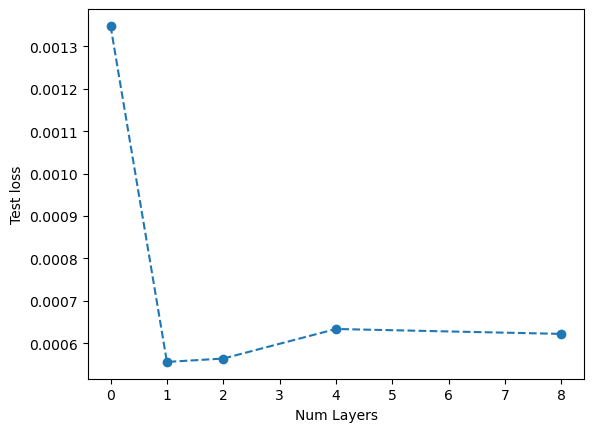

In [16]:
fig, ax = plt.subplots()

results = pd.DataFrame(results).sort_values('messages')

ax.plot(results['messages'], results['loss'], '--o')

ax.set_xlabel('Num Layers')
ax.set_ylabel('Test loss')

The accuracy improves until 4 layers. Our model is not able to benefit from complexity above that.

## Explore readout layers
See how `u0` and `bandgap` require different readouts

In [17]:
results = []
for prop in tqdm(['g4mp2_atom', 'bandgap']):
    # Make the data loaders
    train_loader = make_data_loader('datasets/train_data.proto', batch_size=64, shuffle_buffer=16384, output_property=prop)
    valid_loader = make_data_loader('datasets/valid_data.proto', batch_size=64, output_property=prop)
    test_loader = make_data_loader('datasets/test_data.proto', batch_size=64, output_property=prop)
    
    # Get the true values
    y_true = np.concatenate([x[1] for x in test_loader])
    
    # Test different network designs
    for r in ['sum', 'max']:
        # Make the model
        model = make_model(64, 4, r)

        # Set the scale later
        _, outputs = next(iter(train_loader))
        scale = model.get_layer('scaling')
        scale.mean = outputs.numpy().mean()
        scale.std = outputs.numpy().std()

        # Train the model
        model.compile('adam', loss='mean_squared_error')
        model.fit(train_loader, epochs=128, verbose=False, validation_data=valid_loader, callbacks=cbs)

        # Score the model
        results.append({
            'property': prop,
            'readout': r,
            'y_true': y_true,
            'y_pred': model.predict(test_loader)[:, 0]
        })

  0%|                                                                                                                                                                                                                                                               | 0/2 [00:00<?, ?it/s]/home/lward/miniconda3/envs/mpnn/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-08-14 13:47:42.550001: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:47:42.550056: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 13:47:42.550069: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancell

204/204 [==============================] - 0s 992us/step


2023-08-14 13:49:37.777547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:49:37.777578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 13:49:37.777591: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990
2023-08-14 13:49:43.022453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:49:43.022480: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 13:49:43.022516: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990


204/204 [==============================] - 0s 948us/step


2023-08-14 13:53:20.991912: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 13:53:20.991935: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 13:53:20.991945: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 13:53:20.991958: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1/2 [05:43<05:43, 343.65s/it]2023-08-14 13:53:27.012360: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. K

204/204 [==============================] - 0s 953us/step


2023-08-14 14:00:31.528844: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 14:00:31.528871: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990
2023-08-14 14:00:36.629116: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 14:00:36.968887: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 14:00:36.968914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 14:00:36.968920: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 14:00:36.968923: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv i

204/204 [==============================] - 0s 969us/step


2023-08-14 14:03:45.861365: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6867102267835232283
2023-08-14 14:03:45.861391: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14081827691709263811
2023-08-14 14:03:45.861395: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9636388161030482004
2023-08-14 14:03:45.861401: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10549839945170897990
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [16:08<00:00, 484.26s/it]


In [18]:
results = pd.DataFrame(results)

Plot the predicted versus actual

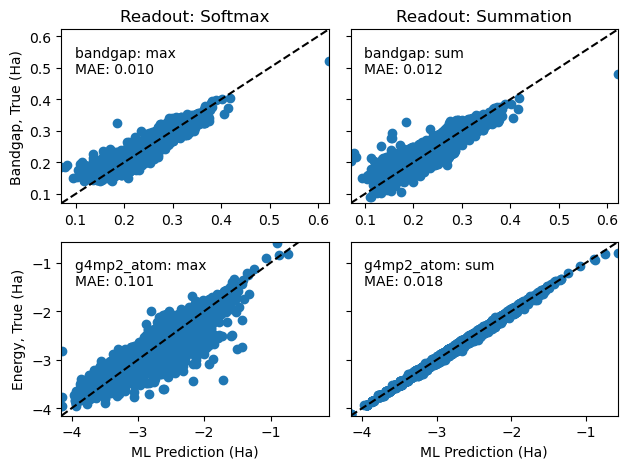

In [19]:
fig, axxs = plt.subplots(2, 2, sharey='row')

for (prop, group), axs in zip(results.groupby('property'), axxs):
    for (readout, record), ax in zip(group.groupby('readout'), axs):
        record = record.iloc[0]
        ax.scatter(record['y_true'], record['y_pred'])
        mae=np.abs(record['y_true'] - record['y_pred']).mean()
        
        # Make it pretty
        ax.text(0.05, 0.75, f'{prop}: {readout}\nMAE: {mae:.3f}', transform=ax.transAxes)
        ax.set_xlim([np.concatenate(record[['y_true', 'y_pred']]).min(),
                     np.concatenate(record[['y_true', 'y_pred']]).max()])
        ax.set_ylim(ax.get_xlim())
        
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
        

# Add some labels
axxs[0, 0].set_title('Readout: Softmax')
axxs[0, 1].set_title('Readout: Summation')

axxs[0, 0].set_ylabel('Bandgap, True (Ha)')
axxs[1, 0].set_ylabel('Energy, True (Ha)')

for ax in axxs[1, :]:
    ax.set_xlabel('ML Prediction (Ha)')
   
fig.tight_layout()

In [20]:
results['mae'] = results.apply(lambda x: np.abs(x['y_pred'] - x['y_true']).mean(), axis=1)

In [22]:
results

,property,readout,y_true,y_pred,mae
0,g4mp2_atom,sum,"[-2.5511, -2.979564, -2.437563, -2.980702, -3....","[-2.5550957, -2.9633243, -2.4467945, -2.994167...",0.018225
1,g4mp2_atom,max,"[-2.5511, -2.979564, -2.437563, -2.980702, -3....","[-2.815916, -2.7887354, -2.4363513, -2.9310098...",0.101010
2,bandgap,sum,"[0.2925, 0.2765, 0.1905, 0.2215, 0.3118, 0.266...","[0.29428595, 0.2581817, 0.17511022, 0.24133493...",0.012034
3,bandgap,max,"[0.2925, 0.2765, 0.1905, 0.2215, 0.3118, 0.266...","[0.2911698, 0.26068956, 0.20165971, 0.22866017...",0.010270
